<a href="https://colab.research.google.com/github/prabhjotschugh/Fish-Detection-YOLOv8/blob/main/Fish_Detection_YOLOv8_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil

In [ ]:
#if not os.path.exists('/kaggle/working/fish-tracking-dataset'):
 #         os.makedirs('/kaggle/working/fish-tracking-dataset')
shutil.copytree('/kaggle/input/fish-tracking-dataset', '/kaggle/working/fish-tracking-dataset')

'/kaggle/working/fish-tracking-dataset'

In [ ]:
from IPython.lib.display import exists
import os
import xml.etree.ElementTree as ET

def xml_to_yolo(xml_file, class_id):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for image_elem in root.findall('image'):
        image_id = image_elem.get('id')
        image_name = image_elem.get('name')
        image_name = image_name.split('images/')[1]
        image_name = image_name.split('.')[0]
        print(image_name)
        image_width = int(image_elem.get('width'))
        image_height = int(image_elem.get('height'))

        yolo_lines = []
        for box_elem in image_elem.findall('box'):
            label = box_elem.get('label')
            occluded = int(box_elem.get('occluded'))
            xtl = float(box_elem.get('xtl'))
            ytl = float(box_elem.get('ytl'))
            xbr = float(box_elem.get('xbr'))
            ybr = float(box_elem.get('ybr'))

            # Calculate center coordinates, width, and height
            center_x = (xtl + xbr) / (2 * image_width)
            center_y = (ytl + ybr) / (2 * image_height)
            width = (xbr - xtl) / image_width
            height = (ybr - ytl) / image_height

            # Create a YOLO line
            yolo_line = f"{class_id} {center_x} {center_y} {width} {height}"

            # Append the YOLO line to the list
            yolo_lines.append(yolo_line)

        # Save YOLO annotations to a text file with the same name as the image_id
        if not os.path.exists('/kaggle/working/train_txt/labels'):
          os.makedirs('/kaggle/working/train_txt/labels')
        txt_file_path = os.path.join('/kaggle/working/train_txt/labels', f"{image_name}.txt")
        with open(txt_file_path, 'w') as txt_file:
            txt_file.write('\n'.join(yolo_lines))

# Directory containing XML annotations
xml_dir = '/kaggle/working/fish-tracking-dataset'

# Define the class ID for the "fish" label
class_id = 0

# Iterate through XML files and convert to YOLO format
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_path = os.path.join(xml_dir, xml_filename)
        xml_to_yolo(xml_path, class_id)

01

02

03

04

05

06

07

08

09

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99


In [ ]:
import random


def split_train_val_data(txt_files_dir, train_dir, val_dir, val_split_ratio=0.2):
    # Create train and validation directories if they don't exist
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

    txt_files = os.listdir(txt_files_dir)
    random.shuffle(txt_files)

    num_val_samples = int(val_split_ratio * len(txt_files))
    val_files = txt_files[:num_val_samples]
    train_files = txt_files[num_val_samples:]

    for val_file in val_files:
        src_txt_path = os.path.join(txt_files_dir, val_file)
        dest_txt_path = os.path.join(val_dir, 'labels', val_file)
        shutil.move(src_txt_path, dest_txt_path)

        # Assuming your image filenames match the annotation filenames with the .jpg extension
        image_filename = os.path.splitext(val_file)[0] + '.jpg'
        src_img_path = os.path.join('/kaggle/working/fish-tracking-dataset/images/', image_filename)
        dest_img_path = os.path.join(val_dir, 'images', image_filename)
        shutil.copy(src_img_path, dest_img_path)

    for train_file in train_files:
        src_txt_path = os.path.join(txt_files_dir, train_file)
        dest_txt_path = os.path.join(train_dir, 'labels', train_file)
        shutil.copy(src_txt_path, dest_txt_path)

        # Assuming your image filenames match the annotation filenames with the .jpg extension
        image_filename = os.path.splitext(train_file)[0] + '.jpg'
        src_img_path = os.path.join('/kaggle/working/fish-tracking-dataset/images/', image_filename)
        dest_img_path = os.path.join(train_dir, 'images', image_filename)
        shutil.move(src_img_path, dest_img_path)

# Directory containing YOLO annotation files
txt_files_dir = '/kaggle/working/train_txt/labels'
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

# Split the data into train and validation sets
split_train_val_data(txt_files_dir, train_dir, val_dir, val_split_ratio=0.2)

In [ ]:
!pip install ultralytics

In [ ]:
!pip install pyyaml

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 166MB/s]


In [ ]:
import yaml

# Define your configuration data as a Python dictionary
config = {
    'path': '/kaggle/working',
    'train': 'train/images',  # train images (relative to 'path') 4 images
    'val': 'val/images',      # val images (relative to 'path') 4 images
    'nc': 1,                   # Number of classes
    'names': ['Fish'],         # Class names
    # 'fl_gamma': 2.0          # Uncomment this line if needed
}

# Define the file path where you want to save the YAML file
yaml_file_path = '/kaggle/working/config.yaml'  # Update with your desired path and file name

# Write the YAML data to the file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(config, yaml_file)

print(f"YAML configuration file saved at: {yaml_file_path}")

YAML configuration file saved at: /kaggle/working/config.yaml


In [ ]:
results = model.train(data='/kaggle/working/config.yaml',
                      epochs=500,
                      imgsz=640,
                      pretrained = True ,
                      name= "fish_small",
                      patience = 35,
                      flipud=0.5,
                      batch = 32,
                      optimizer = 'SGD',
                      augment = True
                      )

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/config.yaml, epochs=500, time=None, patience=35, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=fish_small, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

2024-07-12 05:52:14,643	INFO util.py:124 -- Outdated packages:

  ipywidgets==7.7.1 found, needs ipywidgets>=8

Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.

2024-07-12 05:52:15,493	INFO util.py:124 -- Outdated packages:

  ipywidgets==7.7.1 found, needs ipywidgets>=8

Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1



                   from  n    params  module                                       arguments                     

  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 

  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                

  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             

  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               

  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           

  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              

  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           

  7                  -1  1   1180672  u

wandb: Currently logged in as: prabhjotchugh0805 (prabhjotchugh0805-rediminds). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'

AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...



100%|██████████| 6.25M/6.25M [00:00<00:00, 76.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 1107.06it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

val: Scanning /kaggle/working/val/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1473.94it/s]

val: New cache created: /kaggle/working/val/labels.cache


Plotting labels to runs/detect/fish_small/labels.jpg... 

optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)

TensorBoard: model graph visualization added ✅

Image sizes 640 train, 640 val

Using 2 dataloader workers

Logging results to runs/detect/fish_small

Starting training for 500 epochs...



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      7.89G       1.67      3.314      1.251        321        640: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         19        185      0.542      0.335      0.345      0.218




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      7.92G      1.544      3.223      1.236        260        640: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         19        185      0.638      0.395      0.434       0.28




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      7.77G      1.594      2.977      1.246        245        640: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         19        185      0.774      0.546      0.646      0.423




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      7.78G      1.412      1.926      1.175        320        640: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         19        185      0.908      0.692      0.845      0.557




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      7.78G      1.246      1.268      1.147        247        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         19        185      0.903      0.804      0.889      0.592




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      7.78G      1.216      1.036      1.093        281        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         19        185      0.844      0.875       0.91      0.621




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      7.78G      1.092     0.8729       1.03        269        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


                   all         19        185      0.902       0.87      0.926      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      7.78G      1.085      0.787      1.009        268        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         19        185      0.917      0.886      0.948      0.708




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      7.78G      1.006      0.711     0.9768        253        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         19        185      0.868      0.892      0.938      0.681




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      7.78G     0.9799     0.6838     0.9644        272        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         19        185      0.926      0.881       0.95      0.693




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      7.78G      1.024     0.6286     0.9604        259        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


                   all         19        185      0.951      0.892      0.955      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      7.77G     0.9505     0.6233     0.9404        239        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         19        185      0.962      0.908      0.958      0.714




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      7.78G      0.948     0.5528     0.9344        285        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         19        185       0.95      0.915       0.96      0.701




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      7.91G      0.948     0.5541     0.9218        327        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         19        185       0.94      0.946      0.962      0.732




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      7.79G     0.8995     0.5818     0.9139        305        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         19        185       0.96       0.93      0.962      0.658




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500       7.9G     0.9501     0.5168     0.9358        226        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.956      0.932      0.965      0.773




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      7.82G     0.9899     0.5754     0.9431        294        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         19        185      0.965       0.93      0.966      0.771




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      7.87G     0.9493     0.6068     0.9274        286        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         19        185      0.956      0.939      0.968       0.77




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      7.95G     0.9358     0.5722     0.9128        325        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         19        185      0.945      0.923      0.966      0.727




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      7.81G     0.9328     0.5812      0.905        272        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         19        185      0.973      0.919      0.968       0.73




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      7.78G     0.9013     0.6737     0.9131        303        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         19        185      0.966      0.935      0.967      0.757




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      7.94G     0.8474     0.6196     0.9048        262        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         19        185      0.966       0.93       0.97       0.76




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      7.77G     0.9333     0.6215     0.9113        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         19        185      0.939       0.93      0.966      0.695




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      7.81G      1.024     0.5525     0.9237        270        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         19        185      0.933      0.935      0.963      0.656




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      7.77G      1.013     0.5194     0.9281        273        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         19        185      0.978      0.944      0.973      0.766




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500       7.9G      1.035     0.5467     0.9359        245        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         19        185      0.962      0.949      0.972      0.767




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      7.81G     0.9849     0.5084     0.9131        247        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         19        185      0.975      0.924      0.969      0.677




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      7.81G     0.9927     0.5316     0.9303        283        640: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         19        185      0.965      0.935      0.968       0.69




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500       7.9G      1.012     0.5561     0.9281        286        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         19        185      0.985       0.93      0.972       0.76




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      7.83G      1.013     0.5914     0.9511        366        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         19        185      0.956      0.932      0.972      0.763




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      7.84G     0.9797     0.6729     0.9225        313        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         19        185      0.972      0.925      0.969      0.731




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      7.81G     0.9037     0.7723       0.92        249        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         19        185      0.977      0.914      0.969      0.782




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500       7.9G     0.8661     0.7208     0.9101        271        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         19        185      0.988      0.911      0.971      0.758




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      7.81G     0.8198      0.654     0.8912        218        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         19        185      0.931      0.948       0.97      0.688




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      7.82G     0.9726     0.6362     0.9181        323        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         19        185      0.953       0.93      0.973      0.772




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      7.94G     0.9329     0.6211     0.9197        226        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         19        185      0.956      0.939      0.973      0.772




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      7.77G     0.9371     0.6216     0.9097        331        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         19        185      0.947      0.957       0.97      0.732




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500       7.8G     0.8658     0.5969     0.9011        258        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         19        185      0.985      0.941      0.974      0.707




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      7.77G     0.9836      0.566      0.918        308        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         19        185      0.972      0.952      0.976      0.742




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      7.94G     0.9827     0.5553     0.9253        269        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         19        185      0.962      0.948      0.963      0.744




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      7.78G     0.9968     0.5314     0.9252        288        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.962      0.957      0.972      0.686




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      7.82G     0.9913     0.5472     0.9192        326        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         19        185      0.956       0.95      0.974      0.719




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      7.78G     0.9239     0.5416     0.9208        234        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         19        185      0.983      0.933      0.965      0.743




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      7.94G      0.928     0.5189     0.9012        336        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         19        185      0.989      0.951      0.973      0.724




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      7.79G      1.003     0.5159      0.903        313        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         19        185      0.977      0.946      0.964      0.768




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      7.94G     0.9308     0.5493     0.9244        304        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         19        185      0.994      0.945      0.964      0.766




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      7.79G     0.8655     0.5525     0.9025        265        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         19        185      0.978      0.948      0.969      0.733




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      7.81G     0.8935     0.5352     0.9017        302        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         19        185      0.995      0.941      0.969      0.719




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      7.78G     0.8994     0.5296     0.9086        299        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         19        185      0.997      0.941      0.969      0.735




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      7.81G     0.8852     0.5234     0.9163        270        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         19        185      0.994      0.935      0.969      0.743




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      7.78G     0.8584     0.5118     0.9071        250        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         19        185      0.967      0.949      0.974      0.753




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      7.81G     0.8382     0.4914     0.8958        206        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         19        185       0.98      0.946      0.973      0.761




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      7.77G     0.8809     0.4906      0.901        294        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         19        185      0.988      0.919      0.972      0.734




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      7.99G     0.8443     0.4725     0.9016        317        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         19        185      0.994      0.932      0.963      0.742




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      7.79G     0.8815     0.4923     0.8907        316        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         19        185       0.98      0.951      0.975      0.784




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      7.82G     0.9477     0.5005     0.9068        336        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         19        185      0.982      0.951      0.971      0.773




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      7.77G     0.8537      0.482     0.8918        269        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         19        185      0.989      0.945      0.972      0.754




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      7.85G     0.8768     0.4835     0.8855        342        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         19        185      0.992      0.941      0.972      0.748




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      7.78G     0.8419     0.4735     0.8833        307        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         19        185      0.992      0.957      0.965      0.768




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      7.81G     0.8294     0.4888     0.9021        274        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         19        185      0.985      0.957      0.972      0.763




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      7.77G     0.8283     0.4884     0.8901        258        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         19        185      0.989      0.947      0.968      0.758




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      7.85G     0.7769     0.4772     0.8866        207        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         19        185      0.988      0.951      0.974      0.765




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500       7.9G     0.8086     0.5137     0.8784        295        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         19        185      0.989      0.951      0.977      0.775




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      7.93G     0.7839     0.4942     0.8935        303        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         19        185      0.976      0.951      0.975      0.769




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      7.77G     0.8311     0.4744     0.8973        269        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         19        185      0.986      0.946      0.973      0.786




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      7.86G     0.7987     0.4652     0.8868        278        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         19        185      0.983      0.946      0.964      0.781




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500       7.9G      0.834     0.4631     0.8876        299        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         19        185      0.992      0.946       0.97      0.754




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      7.86G     0.8137     0.4527     0.8864        299        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         19        185      0.994       0.94      0.974       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      7.77G     0.7897     0.4421     0.8831        244        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         19        185      0.983       0.95      0.969      0.799




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      7.97G     0.8038     0.4314     0.8978        305        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         19        185      0.988      0.946      0.973      0.782




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      7.78G     0.8038     0.4255     0.8811        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         19        185      0.993      0.941      0.966       0.76




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      7.86G     0.8137     0.4451     0.8835        297        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         19        185      0.983      0.946      0.978       0.77




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      7.81G     0.8114     0.4485     0.8907        243        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         19        185      0.982      0.951      0.976      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500         8G     0.7644      0.433     0.8776        249        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         19        185      0.987      0.951       0.97      0.804




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      7.77G     0.7939     0.4414     0.8765        339        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         19        185      0.985      0.951      0.976      0.773




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      7.82G     0.7941     0.4354     0.8845        271        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         19        185      0.978      0.947      0.975      0.761




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      7.91G     0.7947     0.4456     0.8733        264        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         19        185       0.98      0.951      0.977      0.802




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      7.81G     0.7859     0.4601     0.8672        341        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         19        185      0.992      0.951      0.978      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      7.78G     0.7586     0.4705      0.872        300        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         19        185      0.989      0.943      0.974      0.778




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      7.94G      0.746      0.458     0.8719        252        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         19        185      0.989      0.948       0.98       0.77




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      7.78G     0.7764     0.4611     0.8741        231        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         19        185      0.983      0.951      0.975      0.791




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      7.81G     0.7965     0.4571      0.879        324        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.983      0.962      0.973      0.783




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500       7.9G     0.7703     0.4509     0.8814        342        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         19        185      0.987      0.957      0.972      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      7.82G     0.7855     0.4344     0.8814        291        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         19        185      0.982      0.957      0.965      0.797




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      7.78G     0.7834     0.4135     0.8807        223        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         19        185      0.983      0.951       0.97       0.78




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      7.82G     0.7671     0.4186     0.8694        242        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         19        185      0.989      0.945      0.969      0.789




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500       7.9G     0.8202     0.4393     0.8775        366        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         19        185      0.989      0.944      0.965      0.786




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      7.81G     0.7603     0.4213      0.879        304        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         19        185      0.988      0.962      0.971      0.786




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      7.78G     0.7814     0.4304     0.8617        314        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         19        185      0.983      0.956      0.972      0.767




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      7.81G     0.7425     0.4231     0.8616        274        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         19        185      0.988      0.957      0.974      0.757




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      7.96G     0.7686     0.4584     0.8751        311        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         19        185       0.99      0.962      0.979      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      7.85G     0.7466     0.4371     0.8851        206        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         19        185      0.983      0.957      0.978      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      7.82G     0.7696     0.4302     0.8703        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         19        185      0.978      0.947      0.975      0.776




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      7.81G     0.7495     0.4082     0.8583        303        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         19        185      0.967      0.949      0.977      0.765




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      7.78G     0.7438     0.4217     0.8638        311        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         19        185      0.979      0.962       0.97      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      7.85G     0.7195     0.4205     0.8614        309        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         19        185       0.98      0.962      0.977      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      7.81G     0.7336     0.4242     0.8616        264        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         19        185      0.982      0.951      0.973       0.78




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      7.99G     0.7164     0.4264     0.8684        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         19        185      0.978      0.954      0.973      0.771




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      7.77G     0.7052     0.4118     0.8536        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         19        185      0.983      0.947      0.976      0.806




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      7.81G     0.7672     0.4318     0.8579        353        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         19        185      0.977      0.962      0.978      0.802




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500       7.9G     0.7044     0.4217     0.8688        274        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         19        185      0.971      0.957      0.975      0.769




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      7.81G     0.7356     0.4287     0.8529        286        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         19        185      0.983      0.957      0.969      0.771




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      7.78G     0.7437     0.4111     0.8648        308        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         19        185      0.991      0.962      0.978      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      7.82G     0.7075     0.3871     0.8604        314        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         19        185      0.983      0.968      0.981      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      7.81G     0.7535     0.3987     0.8652        314        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         19        185      0.981      0.957      0.979      0.777




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      7.85G     0.7128     0.3808     0.8515        290        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         19        185      0.978      0.944       0.97      0.766




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      7.78G     0.7483     0.3901     0.8582        269        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         19        185      0.979      0.962      0.978      0.793




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      7.82G      0.704     0.3884     0.8505        268        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         19        185      0.978      0.946      0.972      0.794




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      7.81G     0.7186     0.4083     0.8578        278        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.983      0.944      0.971      0.779




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      7.81G     0.6957      0.401     0.8474        327        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         19        185      0.977      0.962      0.982      0.782




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      7.78G      0.693     0.4106     0.8524        249        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         19        185      0.989      0.973      0.986      0.804




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      7.81G      0.698     0.3957     0.8577        284        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         19        185      0.984      0.967      0.992      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      7.78G     0.7219     0.4051      0.849        297        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         19        185      0.957      0.966      0.984      0.777




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      7.82G      0.703     0.3933     0.8554        282        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         19        185      0.989      0.968      0.986       0.78




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      7.91G     0.7183     0.4054       0.85        288        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         19        185      0.973      0.968      0.984      0.799




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500       7.8G     0.7096     0.4082     0.8478        267        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         19        185      0.973      0.958      0.984      0.804




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      7.77G     0.6981     0.4022     0.8531        315        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         19        185      0.973      0.958      0.986      0.781




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      7.85G     0.6824     0.3874     0.8429        265        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         19        185      0.978      0.951      0.984      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      7.78G     0.6911     0.3769     0.8438        323        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         19        185      0.982      0.951      0.988      0.789




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500         8G     0.6987     0.3766      0.852        300        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


                   all         19        185      0.968      0.946      0.978      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      7.96G     0.6932     0.3859     0.8525        250        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         19        185      0.962      0.962      0.978      0.798




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      7.81G     0.7124     0.3903     0.8576        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         19        185      0.967      0.955      0.975        0.8




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      7.77G     0.7275     0.3998     0.8505        314        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         19        185      0.967      0.955       0.98      0.802




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      7.81G     0.6835     0.3865     0.8535        298        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         19        185      0.973      0.956      0.981      0.809




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      7.77G     0.6925     0.4017     0.8523        240        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         19        185      0.972      0.955       0.98      0.788




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      7.83G     0.6805     0.3948     0.8443        345        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         19        185      0.971      0.962      0.984      0.796




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      7.77G     0.6756     0.4071     0.8485        228        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         19        185      0.978       0.96      0.983      0.818




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      7.82G     0.6773     0.4015     0.8429        337        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         19        185      0.987      0.951      0.985      0.797




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      7.77G     0.6793     0.3775     0.8534        323        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         19        185      0.983      0.961      0.985      0.805




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      7.98G     0.6666     0.3718     0.8475        263        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         19        185      0.977      0.973      0.986      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      7.77G     0.6593     0.3591     0.8432        282        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         19        185      0.981      0.962      0.985      0.797




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      7.82G     0.6746     0.3687     0.8439        298        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         19        185      0.989      0.956      0.987      0.815




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      7.79G     0.6856     0.3732      0.849        285        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         19        185      0.973      0.962      0.986      0.824




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      7.83G      0.663     0.3656      0.851        295        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         19        185      0.988      0.962      0.984      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      7.91G     0.6827     0.3649     0.8408        268        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         19        185      0.982      0.957      0.979      0.812




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      7.95G     0.6732     0.3665     0.8451        280        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         19        185      0.989      0.961      0.981       0.82




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      7.79G     0.6993     0.3785     0.8388        332        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         19        185      0.983      0.962      0.982      0.819




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      7.81G     0.6609     0.3666     0.8427        300        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         19        185      0.987      0.968      0.985      0.822




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      7.78G     0.6921     0.3723     0.8464        281        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         19        185      0.989      0.962      0.981      0.811




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      7.82G     0.6583     0.3685     0.8422        290        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         19        185      0.983      0.961      0.978      0.795




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      7.78G     0.6762      0.376     0.8623        249        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         19        185      0.983      0.962      0.983       0.82




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      7.94G     0.6635     0.3777     0.8543        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         19        185      0.993      0.951      0.986      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      7.77G     0.6462     0.3714     0.8441        229        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         19        185      0.994      0.956      0.985        0.8




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500       7.8G     0.6566     0.3807     0.8396        276        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         19        185      0.987      0.962      0.982      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500       7.9G     0.6347     0.3732      0.851        238        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         19        185      0.989      0.956      0.976      0.804




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      7.82G     0.6329     0.3712     0.8408        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         19        185      0.989       0.96      0.976        0.8




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      7.78G     0.6764     0.3862     0.8586        218        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         19        185      0.989      0.961      0.975      0.795




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      7.81G     0.6136     0.3548     0.8434        247        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         19        185      0.987      0.968      0.986      0.809




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      7.95G       0.63      0.383     0.8422        263        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         19        185      0.984      0.967      0.986      0.804




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      7.95G     0.6348     0.3891     0.8444        281        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         19        185      0.978      0.968      0.987       0.81




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      7.91G     0.6265     0.3684     0.8386        298        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         19        185      0.977      0.968      0.985      0.805




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      7.81G     0.6534     0.3652     0.8473        219        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         19        185      0.982      0.968      0.985      0.817




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      7.78G     0.6222     0.3494     0.8386        271        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         19        185      0.972      0.968      0.982      0.794




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500       7.8G      0.615     0.3516     0.8415        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         19        185      0.976      0.968      0.984        0.8




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      7.77G     0.6387     0.3732     0.8391        291        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         19        185      0.977      0.968      0.983      0.818




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      7.81G     0.6398     0.3677     0.8439        273        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         19        185      0.987      0.968      0.979      0.798




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      7.82G     0.6446     0.3753     0.8404        265        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         19        185      0.983      0.967      0.978      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      7.82G     0.6486     0.3713     0.8351        283        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         19        185      0.982      0.962      0.981      0.797




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500       7.9G      0.634     0.3599      0.834        293        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         19        185      0.976      0.968      0.984      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      7.81G     0.6268     0.3619     0.8397        331        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         19        185      0.977      0.968      0.978      0.797




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      7.95G     0.6411     0.3739     0.8304        333        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         19        185      0.983      0.961      0.978        0.8




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      7.81G     0.6364     0.3802     0.8401        212        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         19        185      0.983      0.951      0.979      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      7.77G     0.6315     0.3745     0.8412        288        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         19        185      0.976      0.957       0.98      0.809




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      7.82G     0.6289     0.3644     0.8545        225        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         19        185      0.983      0.957      0.981      0.811




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      7.94G     0.6166     0.3562     0.8359        338        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         19        185      0.983      0.957      0.981      0.821




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500       7.8G     0.6527      0.353     0.8356        342        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         19        185      0.988      0.951      0.979      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      7.78G     0.6366     0.3472     0.8336        246        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         19        185      0.987      0.951      0.977      0.807




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      7.84G     0.6272     0.3428     0.8412        306        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         19        185      0.994      0.956      0.978      0.801




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500       7.9G     0.6118     0.3402     0.8432        238        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         19        185      0.992      0.951      0.978      0.823




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      7.85G      0.631     0.3493     0.8389        314        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         19        185      0.991      0.951      0.977       0.82




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      7.78G     0.6427     0.3498     0.8329        325        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         19        185      0.983      0.949      0.977      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      7.82G     0.6202     0.3488     0.8381        286        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         19        185      0.994      0.956      0.981      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      7.78G     0.6336     0.3527     0.8361        302        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         19        185      0.989      0.961      0.982      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500       7.8G     0.6351     0.3449     0.8327        368        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         19        185      0.994      0.951      0.981      0.822




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      7.95G     0.6077     0.3361     0.8268        335        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         19        185      0.989      0.959      0.987      0.809




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      7.86G     0.6074     0.3345     0.8335        244        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         19        185      0.989      0.954      0.986      0.809




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500       7.9G     0.5923     0.3431     0.8333        254        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         19        185      0.992      0.968      0.988      0.828




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      7.83G     0.6105     0.3467     0.8381        300        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         19        185       0.99      0.962      0.986      0.833




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      7.77G     0.6051     0.3636     0.8326        284        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.988      0.957      0.978       0.82




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      7.81G       0.59     0.3661     0.8318        271        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         19        185      0.988      0.968      0.986      0.839




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      7.78G     0.6031     0.3703     0.8215        289        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         19        185      0.994      0.972      0.986      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      7.81G     0.6219     0.3725     0.8397        276        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         19        185      0.993      0.962      0.987      0.837




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      7.79G     0.6036     0.3564     0.8341        301        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         19        185      0.994      0.962      0.984      0.825




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      7.99G     0.5845     0.3517     0.8382        259        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         19        185      0.989      0.965      0.986      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      7.77G     0.5929     0.3448     0.8364        270        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         19        185      0.994      0.967      0.983      0.824




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500       7.8G     0.5811     0.3393     0.8342        256        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         19        185      0.994      0.967      0.982      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      7.79G     0.6055     0.3442     0.8307        315        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         19        185      0.983      0.961      0.981      0.815




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      7.82G     0.5997      0.339     0.8396        273        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         19        185      0.973      0.962      0.981      0.821




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500       7.9G     0.5759      0.336     0.8387        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.989      0.954      0.981      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      7.82G     0.6118     0.3519     0.8339        282        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         19        185      0.988      0.962      0.977      0.812




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      7.77G     0.6023     0.3529     0.8274        264        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         19        185      0.989      0.955      0.984      0.832




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      7.81G     0.6063     0.3532     0.8297        312        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         19        185      0.983      0.961      0.985      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      7.77G     0.6029      0.357     0.8352        308        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         19        185      0.993      0.951      0.982      0.835




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      7.81G     0.6094     0.3597     0.8383        268        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         19        185      0.988      0.957      0.985      0.844




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      7.78G     0.5971      0.347     0.8313        296        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         19        185      0.994      0.949      0.985      0.832




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      7.81G     0.5931     0.3416      0.833        265        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         19        185      0.983      0.962      0.985      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      7.77G     0.5974     0.3522     0.8382        278        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         19        185      0.994      0.957      0.987      0.835




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      7.82G     0.5756      0.339     0.8301        272        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.989      0.965      0.981      0.833




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      7.78G     0.5946     0.3386     0.8289        259        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         19        185      0.992      0.951      0.982      0.819




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500       7.8G     0.5702     0.3261     0.8306        306        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         19        185      0.994      0.958      0.982      0.817




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      7.78G     0.6023     0.3366     0.8302        317        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         19        185      0.993      0.962       0.98      0.824




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      7.81G     0.5608     0.3164     0.8252        252        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         19        185      0.994      0.953       0.98      0.819




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      7.77G     0.6152     0.3293     0.8363        331        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.988      0.962      0.982      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      7.81G       0.59     0.3214     0.8234        273        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.991      0.962       0.98      0.823




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      7.91G     0.5527     0.3213     0.8264        241        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19        185      0.993      0.962       0.98      0.823




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      7.96G     0.5551     0.3297     0.8276        271        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         19        185      0.977      0.973       0.98      0.829




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      7.77G     0.5977      0.354     0.8297        359        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         19        185      0.978      0.973      0.981      0.818




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      7.82G     0.5892      0.347     0.8368        204        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         19        185      0.989      0.972      0.983      0.817




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      7.91G     0.5645     0.3253     0.8172        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         19        185      0.988      0.968      0.981       0.82




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500       7.8G     0.5675      0.328     0.8266        256        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         19        185      0.988      0.973      0.979      0.825




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      7.94G     0.5762     0.3359     0.8327        284        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         19        185      0.987      0.973      0.981      0.816




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500         8G     0.5638     0.3309     0.8214        279        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         19        185      0.988      0.973      0.981      0.803




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      7.77G     0.6187     0.3476     0.8284        307        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         19        185      0.989      0.973      0.979      0.833




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      7.86G     0.6034     0.3428     0.8217        327        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         19        185      0.983      0.966       0.98      0.835




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      7.81G     0.5866     0.3409     0.8262        287        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         19        185      0.984      0.967      0.981      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      7.81G       0.57     0.3284     0.8257        303        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.984      0.971      0.982      0.823




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      7.81G      0.577     0.3324     0.8309        208        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         19        185      0.989      0.973      0.982      0.841




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      7.82G     0.5791      0.333     0.8225        358        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         19        185      0.988      0.968      0.983      0.841




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      7.77G     0.5718     0.3288     0.8205        260        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         19        185      0.988      0.968      0.981       0.83




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      7.81G     0.5721     0.3281      0.828        312        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         19        185      0.989      0.973      0.982      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      7.91G     0.5629     0.3254     0.8367        315        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         19        185      0.992      0.968      0.981      0.842




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      7.81G     0.5656     0.3183       0.83        276        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         19        185      0.989      0.962      0.987      0.849




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      7.77G     0.5791      0.323     0.8263        318        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         19        185      0.978      0.966      0.985      0.824




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      7.82G     0.5602     0.3155      0.821        282        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         19        185      0.995      0.951      0.982      0.831




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      7.81G     0.5683     0.3226     0.8292        229        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         19        185      0.978      0.968      0.982      0.839




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      7.99G     0.5656     0.3238     0.8255        270        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         19        185      0.983      0.964      0.982      0.834




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      7.78G     0.5709      0.332     0.8181        274        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         19        185      0.994       0.96      0.983      0.832




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      7.83G     0.5587     0.3283     0.8302        356        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         19        185      0.986      0.962      0.988      0.837




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      7.78G     0.5936     0.3514     0.8237        317        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         19        185      0.989      0.962      0.985       0.84




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      7.82G     0.5599      0.332      0.828        252        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         19        185      0.989      0.959      0.989      0.842




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      7.78G     0.5324     0.3108     0.8153        222        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         19        185      0.984      0.967      0.985      0.835




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      7.98G     0.5468      0.316     0.8256        297        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         19        185      0.994      0.962      0.984      0.827




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      7.78G     0.5565     0.3239     0.8199        351        640: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         19        185      0.989      0.967      0.982       0.84




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      7.98G     0.5204     0.3091     0.8158        272        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         19        185      0.994      0.962      0.986      0.839




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      7.81G      0.553     0.3195     0.8266        260        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         19        185      0.994      0.962      0.984      0.831




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      7.94G     0.5572      0.312      0.824        261        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         19        185      0.989      0.962      0.981      0.836




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500       7.9G     0.5403     0.3068     0.8247        230        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         19        185      0.988      0.962       0.98      0.834




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      7.85G     0.5533     0.3109     0.8318        241        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         19        185      0.988      0.962      0.979      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500       7.9G      0.552     0.3111     0.8265        389        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         19        185      0.989      0.961       0.98       0.83




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      7.85G     0.5597     0.3192     0.8165        253        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         19        185      0.982      0.962      0.982      0.829




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      7.81G      0.552     0.3176     0.8221        281        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         19        185      0.988      0.957      0.981      0.829




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      7.81G     0.5247      0.309     0.8181        257        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         19        185      0.983      0.962      0.978      0.833




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      7.78G     0.5666     0.3297     0.8241        275        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         19        185      0.988      0.957      0.978      0.815




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      7.81G     0.5176     0.3114     0.8197        234        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         19        185      0.988      0.962       0.98      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      7.77G     0.5405     0.3325     0.8155        282        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         19        185      0.989      0.962      0.981      0.828




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      7.81G     0.5442     0.3312     0.8306        266        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         19        185      0.983      0.962      0.979      0.829




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500       7.9G     0.5368     0.3319     0.8201        247        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         19        185      0.989      0.962      0.981      0.821




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      7.82G      0.517     0.3238     0.8218        296        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         19        185      0.984      0.967      0.981      0.819




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      7.77G     0.5257     0.3219     0.8149        297        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         19        185      0.984      0.967       0.98      0.831




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      7.85G      0.522     0.3183     0.8231        254        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         19        185      0.983      0.962       0.98      0.832




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      7.91G     0.5121     0.3141     0.8214        273        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         19        185      0.984      0.967      0.982       0.83




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      7.94G     0.5379     0.3205     0.8225        319        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         19        185      0.984      0.967      0.987      0.826




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      7.77G     0.5112     0.2988     0.8092        287        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         19        185      0.983      0.962      0.982      0.832




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      7.86G     0.5255     0.3045     0.8094        288        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         19        185      0.983      0.962      0.987      0.834




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      7.77G     0.5165     0.3035     0.8155        212        640: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         19        185      0.984      0.967      0.979      0.829




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      7.83G     0.5362     0.3083     0.8183        236        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         19        185      0.984      0.967       0.98      0.825




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      7.78G     0.5494     0.3166     0.8183        305        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         19        185      0.983      0.962       0.98      0.841

EarlyStopping: Training stopped early as no improvement observed in last 35 epochs. Best results observed at epoch 222, best model saved as best.pt.

To update EarlyStopping(patience=35) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.




257 epochs completed in 0.180 hours.

Optimizer stripped from runs/detect/fish_small/weights/last.pt, 22.5MB

Optimizer stripped from runs/detect/fish_small/weights/best.pt, 22.5MB



Validating runs/detect/fish_small/weights/best.pt...

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


                   all         19        185      0.967      0.962      0.986      0.822

Speed: 0.1ms preprocess, 24.2ms inference, 0.0ms loss, 0.7ms postprocess per image

Results saved to runs/detect/fish_small


lr/pg0,█▇▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▁▂▄▅▇█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄
lr/pg2,▁▂▄▅▇█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄
metrics/mAP50(B),▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██▇▇▇██▇█▇██████▇▇
metrics/mAP50-95(B),▁▅▆▅▄▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇████████████
metrics/precision(B),▁▂▅▆▆▅▅█▇▇█▇█▇▇▇▇▇▆▆██▇▇▇▇███▆▇██▇█▇█▇▇▇
metrics/recall(B),▁▆▇▇▇▇▇▇▇█▇▇▇█████▇█████████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▅▄▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
model = YOLO('/kaggle/working/runs/detect/fish_small/weights/best.pt')
results = model.val()
for i in [0.25,0.15,0.05]:
  results = model.val(name= f'cofidence: {i}', conf= i , iou=0.8)

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


                   all         19        185      0.989      0.962      0.987      0.845

Speed: 0.7ms preprocess, 77.4ms inference, 0.0ms loss, 31.2ms postprocess per image

Results saved to runs/detect/val

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         19        185      0.983      0.962      0.985       0.86

Speed: 0.2ms preprocess, 7.1ms inference, 0.0ms loss, 0.8ms postprocess per image

Results saved to runs/detect/cofidence: 0.25

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


                   all         19        185      0.983      0.962      0.985      0.859

Speed: 0.2ms preprocess, 7.0ms inference, 0.0ms loss, 2.1ms postprocess per image

Results saved to runs/detect/cofidence: 0.15

Ultralytics YOLOv8.2.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


                   all         19        185      0.983      0.962      0.984      0.858

Speed: 0.2ms preprocess, 7.0ms inference, 0.0ms loss, 0.7ms postprocess per image

Results saved to runs/detect/cofidence: 0.05


In [ ]:
model = YOLO('/kaggle/working/runs/detect/fish_small/weights/best.pt')

In [ ]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import warnings
warnings.simplefilter('ignore')

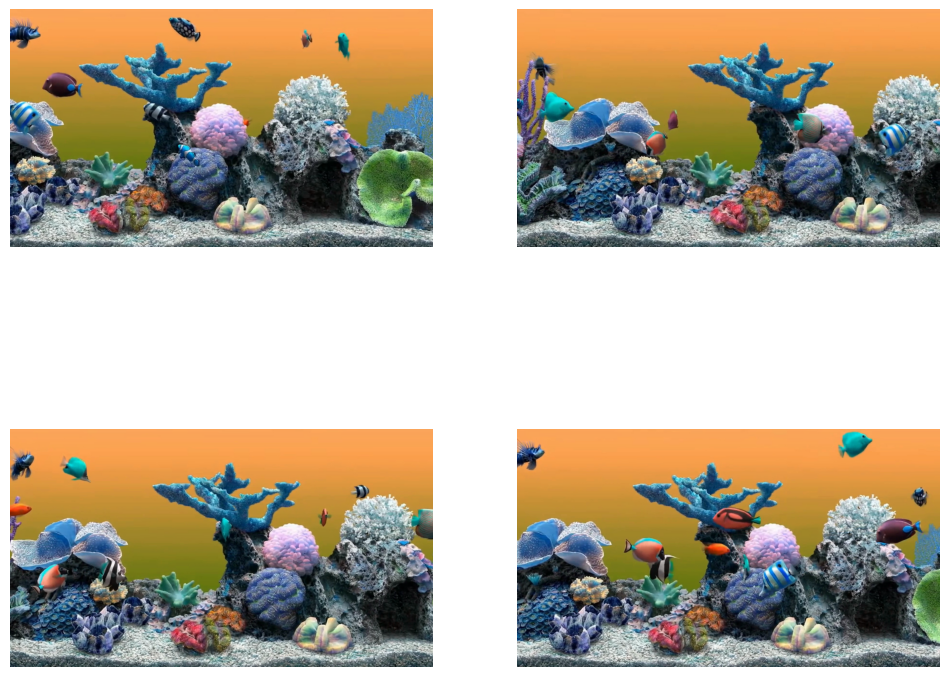

In [ ]:
root_path = '/kaggle/working/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(12,10))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')

In [ ]:
images = []
for i in range(num_samples):
    yolo_outputs = model.predict(random_image[i])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f'In this image {len(box)} fish has been detected.')
        print(f'Fish {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------')

    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])



image 1/1 /kaggle/working/val/images/85.jpg: 384x640 8 Fishs, 82.0ms

Speed: 2.0ms preprocess, 82.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

**********************

In this image 8 fish has been detected.

Fish 1 is: Fish

Coordinates are: [658.3956298828125, 31.940771102905273, 792.20166015625, 139.80435180664062]

Confidence is: 0.9

-------

In this image 8 fish has been detected.

Fish 2 is: Fish

Coordinates are: [0.0, 28.59452247619629, 129.3161163330078, 165.83680725097656]

Confidence is: 0.9

-------

In this image 8 fish has been detected.

Fish 3 is: Fish

Coordinates are: [133.07879638671875, 261.02685546875, 306.4018859863281, 372.06512451171875]

Confidence is: 0.89

-------

In this image 8 fish has been detected.

Fish 4 is: Fish

Coordinates are: [0.0, 384.84136962890625, 127.49935150146484, 514.3700561523438]

Confidence is: 0.89

-------

In this image 8 fish has been detected.

Fish 5 is: Fish

Coordinates are: [549.9672241210938, 388.67

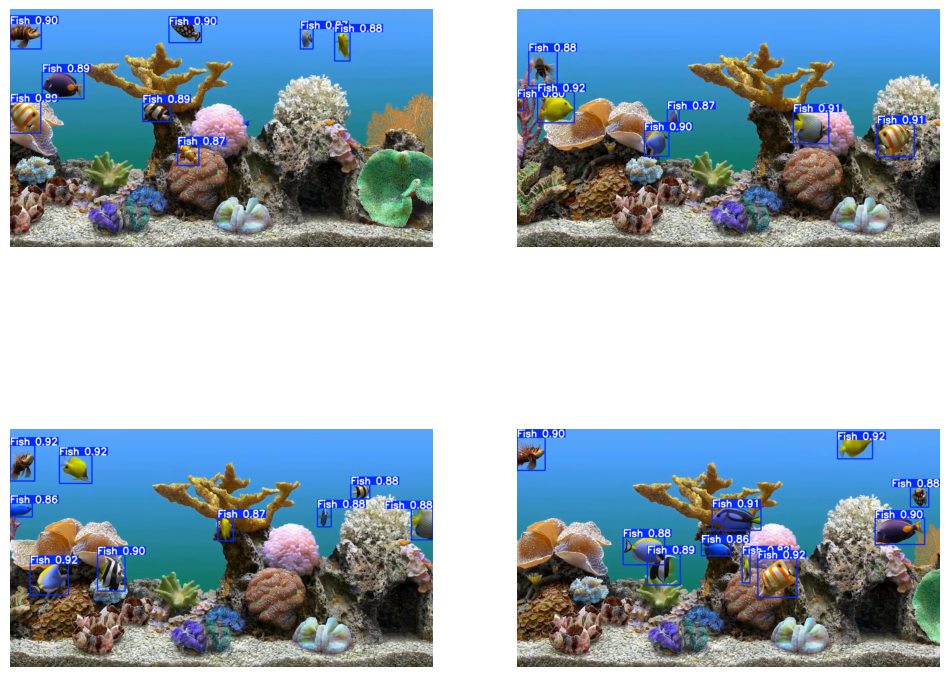

In [ ]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
result = pd.read_csv('/kaggle/working/runs/detect/fish_small/results.csv')
result.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.6698,3.3138,1.2507,0.54236,0.33514,0.34455,0.21761,1.1684,2.12900,1.1505,0.098200,0.000200,0.000200
1,2,1.5441,3.2234,1.2358,0.63754,0.39459,0.43381,0.27957,1.1756,1.96710,1.1574,0.095499,0.000499,0.000499
2,3,1.5944,2.9769,1.2463,0.77395,0.54595,0.64559,0.42280,1.1548,1.38310,1.1770,0.092797,0.000797,0.000797
3,4,1.4116,1.9261,1.1752,0.90800,0.69189,0.84516,0.55749,1.1420,1.19450,1.1920,0.090093,0.001094,0.001094
4,5,1.2464,1.2683,1.1465,0.90291,0.80435,0.88931,0.59153,1.0868,0.95787,1.1238,0.087389,0.001389,0.001389


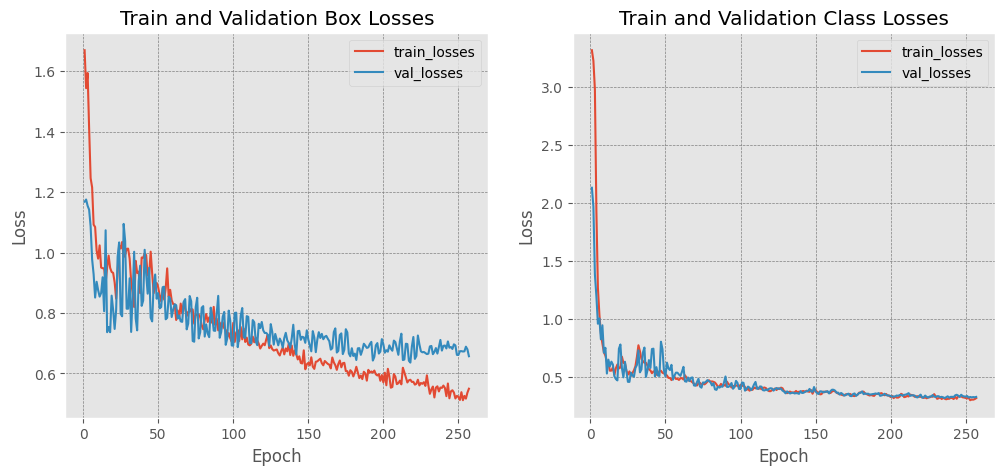

In [ ]:
# Remove leading and trailing spaces from column names
result.columns = result.columns.str.strip()

epoch_column = result['epoch']
box_train_losses = result['train/box_loss']
box_val_losses = result['val/box_loss']
cls_train_losses = result['train/cls_loss']
cls_val_losses = result['val/cls_loss']

plt.figure(figsize=(12,5))
plt.style.use('ggplot')  # You can choose a style you prefer
plt.subplot(1,2,1)
plt.plot(epoch_column, box_train_losses, label='train_losses')
plt.plot(epoch_column, box_val_losses, label='val_losses')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')# Add a grid
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Box Losses')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_column, cls_train_losses, label='train_losses')
plt.plot(epoch_column, cls_val_losses, label='val_losses')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')# Add a grid
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Class Losses')
plt.legend()
plt.show()

(-0.5, 2399.5, 1199.5, -0.5)

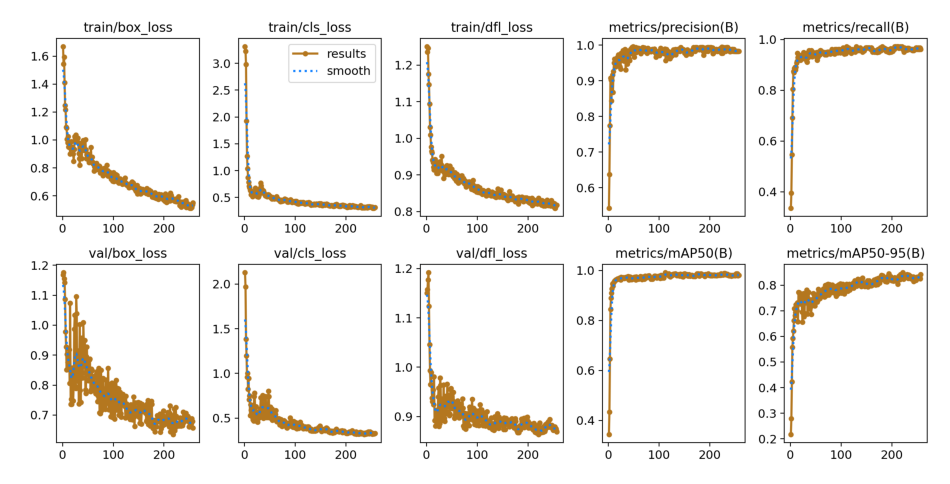

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(cv2.imread('/kaggle/working/runs/detect/fish_small/results.png'))
plt.axis('off')